<a href="https://colab.research.google.com/github/KollexTheAnalyst/Electricity-Forecast/blob/main/ElectricityForcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!get clone https://github.com/Autarky-Power/National-Electricity-Forecasting

/bin/bash: line 1: get: command not found


In [ ]:
!git clone https://github.com/Autarky-Power/National-Electricity-Forecasting

Cloning into 'National-Electricity-Forecasting'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 82 (delta 10), reused 79 (delta 10), pack-reused 0
Receiving objects: 100% (82/82), 35.70 MiB | 27.26 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [ ]:
pip install --upgrade tensorflow

In [ ]:
pip install --upgrade --user tf-nightly tfp-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 22.0 MB/s eta 0:00:00


In [ ]:
import gc
import os
import time
# I need to set a specific GPU to use. Set to -1 if no GPU is present
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import backend as K
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import data as data_tensor
from tensorflow_probability import distributions as tfp
from statsmodels.tsa.seasonal import seasonal_decompose

### **Load Data**

In [ ]:
Data = pd.read_csv('MT_deterministic_data_updated2.csv')
Data

,Index,year,month,day,wday,temp,HD,CD,HD_2,CD_2,...,thu,fri,sat,mid_load,dec,sun,summer,winter,day_of_month,target_residuals
0,1,2013,1,HD,Di,-4.097832,22.397832,0.0,501.662880,0.0,...,0,0,0,77.253881,0,0,0,1,1,-157.162194
1,2,2013,1,WD,Mi,-3.919938,22.219938,0.0,493.725635,0.0,...,0,0,0,1593.337215,0,0,0,1,2,157.162194
2,3,2013,1,WD,Do,-1.456409,19.756409,0.0,390.315703,0.0,...,1,0,0,2274.087215,0,0,0,1,3,-679.388545
3,4,2013,1,WD,Fr,-0.694651,18.994651,0.0,360.796777,0.0,...,0,1,0,2413.670548,0,0,0,1,4,-356.130926
4,5,2013,1,WE,Sa,-1.376359,19.676359,0.0,387.159097,0.0,...,0,0,1,1948.878881,0,1,0,1,5,-12.642208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,2916,2020,12,WE,So,-4.305597,22.605597,0.0,511.013036,0.0,...,0,0,0,2229.190868,0,0,0,1,27,452.979150
2916,2917,2020,12,WD,Mo,-2.418863,20.718863,0.0,429.271264,0.0,...,0,0,0,3881.857534,0,0,0,1,28,1136.773285
2917,2918,2020,12,WD,Di,0.772182,17.527818,0.0,307.224421,0.0,...,0,0,0,3417.482534,0,0,0,1,29,637.908152
2918,2919,2020,12,WD,Mi,1.728469,16.571531,0.0,274.615625,0.0,...,0,0,0,2957.440868,0,0,0,1,30,443.503123


In [ ]:
Data = Data.rename(columns={'target_residuals': 'Values'})

Set the datetime as index

In [ ]:
Data.index = pd.to_datetime(Data['month'].astype(str) + '-' + Data['day_of_month'].astype(str)+ '-'+ Data['year'].astype(str))


Initialize the scaler

In [ ]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

Add Sin and Cosine representation of the year

In [ ]:
def sine_cosine_year(Data):
    day = 24 * 60 * 60
    year = (365.2425) * day
    timestamp_s = Data.index.map(pd.Timestamp.timestamp)
    Data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    Data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    return Data
Data = sine_cosine_year(Data)

In [ ]:
Data.columns

Index(['Index', 'year', 'month', 'day', 'wday', 'temp', 'HD', 'CD', 'HD_2',
       'CD_2', 'HD_3', 'CD_3', 'HD_m1', 'HD_m2', 'CD_m1', 'CD_m2', 'temp_m1',
       'temp_m2', 'jan', 'feb', 'mar', 'apr', 'mai', 'jun', 'jul', 'aug',
       'sep', 'okt', 'nov', 'we', 'ToD', 'mon', 'tue', 'wed', 'thu', 'fri',
       'sat', 'mid_load', 'dec', 'sun', 'summer', 'winter', 'day_of_month',
       'Values', 'Year sin', 'Year cos'],
      dtype='object')

Fixing Error in the day-of-month column

In [ ]:
Data_with_wrong_reports = Data[Data['day_of_month']==0]
for year in Data['year'].unique():
    year_Data = Data_with_wrong_reports[Data_with_wrong_reports['year']==year]
    for month in year_Data['month'].unique():
        month_Data = year_Data[year_Data['month']==month]
        increasing_number = pd.Series(range(1, len(month_Data)+1), index=month_Data.index)
        Data.loc[month_Data.index, 'day_of_month'] = increasing_number

Drop unused data columns

In [ ]:
data = Data.drop(columns=['Index','day', 'wday', 'mid_load', 'HD','CD', 'HD_2', 'CD_2', 'HD_3', 'CD_3','HD_m1','HD_m2','CD_m1','CD_m2'])

data

,year,month,temp,temp_m1,temp_m2,jan,feb,mar,apr,mai,...,fri,sat,dec,sun,summer,winter,day_of_month,Values,Year sin,Year cos
2013-01-01,2013,1,-4.097832,-4.097000,-4.097000,1,0,0,0,0,...,0,0,0,0,0,1,1,-157.162194,0.009848,0.999952
2013-01-02,2013,1,-3.919938,-4.097832,-4.097000,1,0,0,0,0,...,0,0,0,0,0,1,2,157.162194,0.027048,0.999634
2013-01-03,2013,1,-1.456409,-3.919938,-4.097832,1,0,0,0,0,...,0,0,0,0,0,1,3,-679.388545,0.044240,0.999021
2013-01-04,2013,1,-0.694651,-1.456409,-3.919938,1,0,0,0,0,...,1,0,0,0,0,1,4,-356.130926,0.061418,0.998112
2013-01-05,2013,1,-1.376359,-0.694651,-1.456409,1,0,0,0,0,...,0,1,0,1,0,1,5,-12.642208,0.078579,0.996908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,2020,12,-4.305597,-1.785778,-0.803576,0,0,0,0,0,...,0,0,0,0,0,1,27,452.979150,-0.075062,0.997179
2020-12-28,2020,12,-2.418863,-4.305597,-1.785778,0,0,0,0,0,...,0,0,0,0,0,1,28,1136.773285,-0.057898,0.998323
2020-12-29,2020,12,0.772182,-2.418863,-4.305597,0,0,0,0,0,...,0,0,0,0,0,1,29,637.908152,-0.040716,0.999171
2020-12-30,2020,12,1.728469,0.772182,-2.418863,0,0,0,0,0,...,0,0,0,0,0,1,30,443.503123,-0.023523,0.999723


Add elections in 2014 and 2019

In [ ]:
data['elections']= 0
data['elections'][data['year']==2019]=1
data['elections'][data['year']==2014]=1
data['elections'][data['month']>5]=0
data[data['year']==2019]

<ipython-input-9-08c8e8cd3c2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['elections'][data['year']==2019]=1
<ipython-input-9-08c8e8cd3c2c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['elections'][data['year']==2014]=1
<ipython-input-9-08c8e8cd3c2c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['elections'][data['month']>5]=0


,year,month,temp,temp_m1,temp_m2,jan,feb,mar,apr,mai,...,sat,dec,sun,summer,winter,day_of_month,Values,Year sin,Year cos,elections
2019-01-01,2019,1,-5.385798,-4.097000,-4.097000,1,0,0,0,0,...,0,0,0,0,1,1,-1630.171371,0.002021,0.999998,1
2019-01-02,2019,1,-2.278521,-5.385798,-4.097000,1,0,0,0,0,...,0,0,0,0,1,2,-1041.882954,0.019223,0.999815,1
2019-01-03,2019,1,-4.099056,-2.278521,-5.385798,1,0,0,0,0,...,0,0,0,0,1,3,-692.439419,0.036419,0.999337,1
2019-01-03,2019,1,-6.244454,-4.099056,-2.278521,1,0,0,0,0,...,0,0,0,0,1,3,-71.930059,0.036419,0.999337,1
2019-01-05,2019,1,-7.316396,-6.244454,-4.099056,1,0,0,0,0,...,1,0,1,0,1,5,-49.272939,0.070773,0.997492,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,2019,12,1.240626,2.371258,2.290928,0,0,0,0,0,...,0,0,0,0,1,27,-578.798691,-0.088050,0.996116,0
2019-12-28,2019,12,0.186297,1.240626,2.371258,0,0,0,0,0,...,1,0,1,0,1,28,-114.236316,-0.070902,0.997483,0
2019-12-29,2019,12,-1.906868,0.186297,1.240626,0,0,0,0,0,...,0,0,0,0,1,29,-605.053519,-0.053733,0.998555,0
2019-12-30,2019,12,-3.346923,-1.906868,0.186297,0,0,0,0,0,...,0,0,0,0,1,30,-1258.229678,-0.036548,0.999332,0


In [ ]:
data.columns

Index(['year', 'month', 'temp', 'temp_m1', 'temp_m2', 'jan', 'feb', 'mar',
       'apr', 'mai', 'jun', 'jul', 'aug', 'sep', 'okt', 'nov', 'we', 'ToD',
       'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'dec', 'sun', 'summer',
       'winter', 'day_of_month', 'Values', 'Year sin', 'Year cos',
       'elections'],
      dtype='object')

In [ ]:
from google.colab import files

kola = pd.DataFrame(data)
csv_filename = 'main_datasets_alt.csv'
kola.to_csv(csv_filename, index=False)
files.download(csv_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data['Values'].count()

2920

First Basic Visualization of Values (Target_residuals) from Mid_Linear regression models

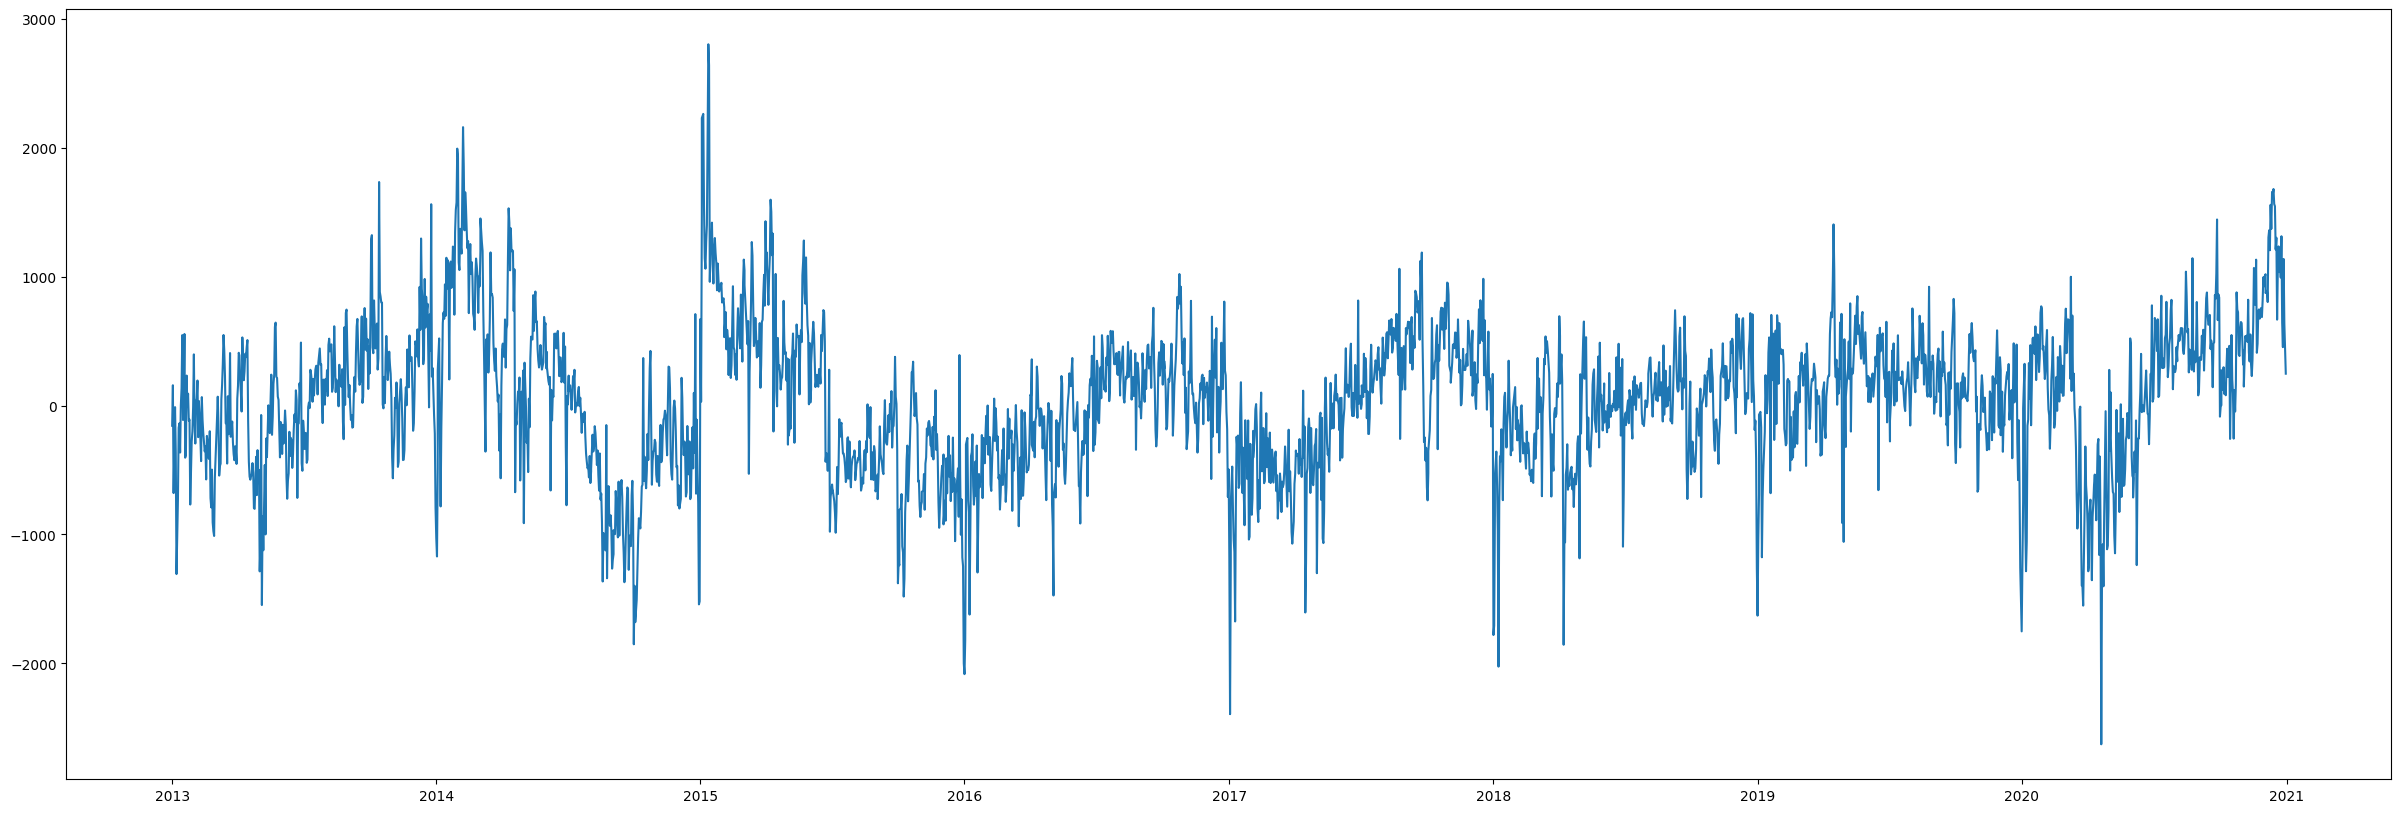

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(30,10))
plt.plot(data['Values'])

MODELLING PROPER (Encoder - Decoder with Attention and GRU Algorithm)  - GRU 1_Model

In [ ]:
class cnn_model:
    def __init__(self, input_length, output_length):
        self.model = None
        self.input_length = input_length
        self.output_length = output_length
        self.data = None

    def load_model(self,features_cnn, features_decoder):
        n_units_1 = 64


        # define training encoder
        input_shape = (self.input_length, features_cnn)
        encoder_inputs = tf.keras.layers.Input(shape=input_shape, name='Encoder Input')
        # first encoder layer
        gru_enc = tf.keras.layers.GRU(n_units_1, activation='tanh', return_state=True, return_sequences=True, dropout=0.1, name = 'GRU_encoder_1')
        encoder_outputs_1, state_h_1 = gru_enc(encoder_inputs)
        encoder_states_1 = [state_h_1]



        # define training decoder
        input_decoder = tf.keras.layers.Input(shape=(self.output_length, features_decoder), name = 'Decoder Input')
        decoder_gru_1 = tf.keras.layers.GRU(n_units_1, activation='tanh', return_sequences=True, return_state=True, dropout=0.1, name = 'GRU_decoder_1')
        decoder_outputs_1, _ = decoder_gru_1(input_decoder, initial_state=encoder_states_1)
        attention = tf.keras.layers.Attention(causal = True)([decoder_outputs_1, encoder_outputs_1])
        concat_out = tf.keras.layers.Concatenate()([decoder_outputs_1, attention])
        dense_output = tf.keras.layers.Dense(1, activation='relu')
        dense_output_output = dense_output(concat_out)
        # define training encoder-decoder
        model = tf.keras.Model([encoder_inputs, input_decoder], [dense_output_output])
        # return all models
        return model


    def supervised_data(self, data, train_test_split, scaler_x, scaler_y):
        # we need three containers storing: encoder data, decoder data and target data
        encoder_in_train = []
        decoder_in_train = []
        target_train = []
        # here i split the defined input length and output length from the data which is then the data which is needed to do the forecast on 2019 and 2020
        data_for_validation = data.iloc[-self.input_length - self.output_length:, :]
        # this data is used to calculate the train dataset. it is important to note that I split the forecasting horizon from the dataset. This ensures that we do not have future information in dataset
        data_for_train = data.iloc[:-self.output_length, :]
        # get all column names to split the features from the target values
        train_columns= data_for_train.drop(columns=['Values']).columns
        # now we have to fit the scaler and transform the data in a range of 0 to 1
        # it is important that we split the data before because otherwise we would make new information about min and maximum values available for the network!
        # I always use two scalers for that one for features and one for target values
        data_for_train[train_columns] = scaler_x.fit_transform(data_for_train[train_columns])
        data_for_train['Values'] = scaler_y.fit_transform(data_for_train['Values'].values.reshape(-1,1))
        # with the fitted scaler we now transform the features of the future data.
        data_for_validation[train_columns] = scaler_x.transform(data_for_validation[train_columns])
        data_for_validation['Values'] = scaler_y.transform(data_for_validation['Values'].values.reshape(-1,1))
        # lets get our training dataset prepared
        # we iterate over all data in the dataset and we use i as the first datapoint from which our dataset starts
        # i + input_lenghth -> data for encoder
        # i + input_length until i + input_length + output_length -> data for decoder
        for i in range(0, len(data_for_train) - self.output_length - self.input_length):
            encoder_index = i + self.input_length
            decoder_index = i + self.input_length + self.output_length
            encoder_in_train.append(
                data_for_train.iloc[i:encoder_index, :].values.reshape(self.input_length, data_for_train.shape[1]))
            # as discussed I drop here future temperature values
            decoder_in_train.append(data_for_train.iloc[encoder_index:decoder_index, :].drop(
                columns=['temp', 'temp_m1', 'temp_m2', 'Values']).values.reshape(self.output_length,
                                                                                data_for_train.shape[1] - 4))
            target_train.append(
                data_for_train.iloc[encoder_index:decoder_index, :]['Values'].values.reshape(self.output_length, 1))
        # for simplicity we use tensorflow dataset because we can then do a train/test split and batching easily but first we have to glue our data  together as needed
        # therefor we combine our input data into one tensorflow dataset
        input_tensors_train = data_tensor.Dataset.from_tensor_slices((encoder_in_train, decoder_in_train))
        # we put our output data into another dataset
        output_tensor_train = data_tensor.Dataset.from_tensor_slices(np.array(target_train))
        # now we can zip them together and have a full encoder_in, decoder_in, target dataset. Shuffling should ensure that we do not have just e.g. the first three years for training, than the following 2 in test
        # it is important that we get latest changes into it aswell. Thats why I like shuffling
        total_train_data = data_tensor.Dataset.zip((input_tensors_train, output_tensor_train)).shuffle(192)
        # now we do the train/test split with the shuffled data
        train_data = total_train_data.take(int(len(decoder_in_train) * train_test_split))
        test_data = total_train_data.skip(int(len(decoder_in_train) * train_test_split))
        # lastly we have to define the encoder-in, decoder_in and output for 2019 and 2020
        encoder_in_val = np.array(data_for_validation.iloc[0:self.input_length, :].values).reshape(1, self.input_length,data_for_train.shape[1] )
        decoder_in_val = np.array(data_for_validation.iloc[self.input_length:, :].drop(
            columns=['temp', 'temp_m1', 'temp_m2', 'Values']).values).reshape(1, self.output_length,
                                                                                data_for_train.shape[1] - 4)
        target_val = np.array(data_for_validation.iloc[self.input_length:, :]['Values'].values)
        self.data = {'train': train_data, 'test': test_data, 'val': [encoder_in_val, decoder_in_val, target_val]}
        return self.data

cnn = cnn_model(365, 365*2)
#model = cnn.load_model(43, 39)
model = cnn.load_model(33, 29)
train_dataset = cnn.supervised_data(data, 0.75, scaler_x, scaler_y)


<ipython-input-14-4472a3285b58>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_train[train_columns] = scaler_x.fit_transform(data_for_train[train_columns])
<ipython-input-14-4472a3285b58>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_train['Values'] = scaler_y.fit_transform(data_for_train['Values'].values.reshape(-1,1))
<ipython-input-14-4472a3285b58>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Encoder Input (InputLayer)  [(None, 365, 33)]            0         []                            
                                                                                                  
 Decoder Input (InputLayer)  [(None, 730, 29)]            0         []                            
                                                                                                  
 GRU_encoder_1 (GRU)         [(None, 365, 64),            19008     ['Encoder Input[0][0]']       
                              (None, 64)]                                                         
                                                                                                  
 GRU_decoder_1 (GRU)         [(None, 730, 64),            18240     ['Decoder Input[0][0]',   

## **GRU 2_Model**

In [ ]:
class cnn_model:
    def __init__(self, input_length, output_length):
        self.model = None
        self.input_length = input_length
        self.output_length = output_length
        self.data = None

    def load_model(self,features_cnn, features_decoder):
        n_units_1 = 128


        # define training encoder
        input_shape = (self.input_length, features_cnn)
        encoder_inputs = tf.keras.layers.Input(shape=input_shape, name='Encoder Input')
        # first encoder layer
        gru_enc = tf.keras.layers.GRU(n_units_1, activation='sigmoid', return_state=True, return_sequences=True, dropout=0.2, name = 'GRU_encoder_1')
        encoder_outputs_1, state_h_1 = gru_enc(encoder_inputs)
        encoder_states_1 = [state_h_1]


        # define training decoder
        input_decoder = tf.keras.layers.Input(shape=(self.output_length, features_decoder), name = 'Decoder Input')
        decoder_gru_1 = tf.keras.layers.GRU(n_units_1, activation='tanh', return_sequences=True, return_state=True, dropout=0.2, name = 'GRU_decoder_1')
        decoder_outputs_1, _ = decoder_gru_1(input_decoder, initial_state=encoder_states_1)
        attention = tf.keras.layers.Attention(causal = True)([decoder_outputs_1, encoder_outputs_1])
        concat_out = tf.keras.layers.Concatenate()([decoder_outputs_1, attention])
        dense_output = tf.keras.layers.Dense(1, activation='relu')
        dense_output_output = dense_output(concat_out)
        # define training encoder-decoder
        model_alt = tf.keras.Model([encoder_inputs, input_decoder], [dense_output_output])
        # return all models
        return model_alt


    def supervised_data(self, data, train_test_split, scaler_x, scaler_y):
        # we need three containers storing: encoder data, decoder data and target data
        encoder_in_train = []
        decoder_in_train = []
        target_train = []
        # here i split the defined input length and output length from the data which is then the data which is needed to do the forecast on 2019 and 2020
        data_for_validation = data.iloc[-self.input_length - self.output_length:, :]
        # this data is used to calculate the train dataset. it is important to note that I split the forecasting horizon from the dataset. This ensures that we do not have future information in dataset
        data_for_train = data.iloc[:-self.output_length, :]
        # get all column names to split the features from the target values
        train_columns= data_for_train.drop(columns=['Values']).columns
        # now we have to fit the scaler and transform the data in a range of 0 to 1
        # it is important that we split the data before because otherwise we would make new information about min and maximum values available for the network!
        # I always use two scalers for that one for features and one for target values
        data_for_train[train_columns] = scaler_x.fit_transform(data_for_train[train_columns])
        data_for_train['Values'] = scaler_y.fit_transform(data_for_train['Values'].values.reshape(-1,1))
        # with the fitted scaler we now transform the features of the future data.
        data_for_validation[train_columns] = scaler_x.transform(data_for_validation[train_columns])
        data_for_validation['Values'] = scaler_y.transform(data_for_validation['Values'].values.reshape(-1,1))
        # lets get our training dataset prepared
        # we iterate over all data in the dataset and we use i as the first datapoint from which our dataset starts
        # i + input_lenghth -> data for encoder
        # i + input_length until i + input_length + output_length -> data for decoder
        for i in range(0, len(data_for_train) - self.output_length - self.input_length):
            encoder_index = i + self.input_length
            decoder_index = i + self.input_length + self.output_length
            encoder_in_train.append(
                data_for_train.iloc[i:encoder_index, :].values.reshape(self.input_length, data_for_train.shape[1]))
            # as discussed I drop here future temperature values
            decoder_in_train.append(data_for_train.iloc[encoder_index:decoder_index, :].drop(
                columns=['temp', 'temp_m1', 'temp_m2', 'Values']).values.reshape(self.output_length,
                                                                                data_for_train.shape[1] - 4))
            target_train.append(
                data_for_train.iloc[encoder_index:decoder_index, :]['Values'].values.reshape(self.output_length, 1))
        # for simplicity we use tensorflow dataset because we can then do a train/test split and batching easily but first we have to glue our data  together as needed
        # therefor we combine our input data into one tensorflow dataset
        input_tensors_train = data_tensor.Dataset.from_tensor_slices((encoder_in_train, decoder_in_train))
        # we put our output data into another dataset
        output_tensor_train = data_tensor.Dataset.from_tensor_slices(np.array(target_train))
        # now we can zip them together and have a full encoder_in, decoder_in, target dataset. Shuffling should ensure that we do not have just e.g. the first three years for training, than the following 2 in test
        # it is important that we get latest changes into it aswell. Thats why I like shuffling
        total_train_data = data_tensor.Dataset.zip((input_tensors_train, output_tensor_train)).shuffle(192)
        # now we do the train/test split with the shuffled data
        train_data = total_train_data.take(int(len(decoder_in_train) * train_test_split))
        test_data = total_train_data.skip(int(len(decoder_in_train) * train_test_split))
        # lastly we have to define the encoder-in, decoder_in and output for 2019 and 2020
        encoder_in_val = np.array(data_for_validation.iloc[0:self.input_length, :].values).reshape(1, self.input_length,data_for_train.shape[1] )
        decoder_in_val = np.array(data_for_validation.iloc[self.input_length:, :].drop(
            columns=['temp', 'temp_m1', 'temp_m2', 'Values']).values).reshape(1, self.output_length,
                                                                                data_for_train.shape[1] - 4)
        target_val = np.array(data_for_validation.iloc[self.input_length:, :]['Values'].values)
        self.data = {'train': train_data, 'test': test_data, 'val': [encoder_in_val, decoder_in_val, target_val]}
        return self.data

cnn = cnn_model(365, 365*2)
#model = cnn.load_model(43, 39)
model_alt = cnn.load_model(33, 29)
train_dataset_alt = cnn.supervised_data(data, 0.80, scaler_x, scaler_y)


<ipython-input-14-f2adae81fe63>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_train[train_columns] = scaler_x.fit_transform(data_for_train[train_columns])
<ipython-input-14-f2adae81fe63>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_train['Values'] = scaler_y.fit_transform(data_for_train['Values'].values.reshape(-1,1))
<ipython-input-14-f2adae81fe63>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [ ]:
model_alt.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Encoder Input (InputLayer)  [(None, 365, 33)]            0         []                            
                                                                                                  
 Decoder Input (InputLayer)  [(None, 730, 29)]            0         []                            
                                                                                                  
 GRU_encoder_1 (GRU)         [(None, 365, 128),           62592     ['Encoder Input[0][0]']       
                              (None, 128)]                                                        
                                                                                                  
 GRU_decoder_1 (GRU)         [(None, 730, 128),           61056     ['Decoder Input[0][0]',   

In [ ]:
@tf.function
def train_step(model, x_batch_train, y_batch_train, optimizer, loss_fn, train_acc_metric):
    """
    Function

        Training on one batch

    Parameter

        model : keras.model
            ai model for forecasting

        x_batch_train : tensor.batch
            batched tensor containing training feature data

        y_batch_train : tensor.batch
            batched tensor containing training measurement data

        optimizer : keras.optimizer
            Optimizer used for training

        loss_fn : keras.loss_function
            loss function to calculate accuracy
        train_acc_metric : keras.loss_function

            accuracy metric

    Return

        loss_value : keras.loss
            loss value
    """
    with tf.GradientTape() as tape:
        logits = model(x_batch_train, training=True)  # Logits for this minibatch
        loss_value = loss_fn(y_batch_train, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y_batch_train, logits)
    _ = gc.collect()
    return loss_value

@tf.function
def test_step(model, x_batch_val, y_batch_val, val_acc_metric):
    """
    Function

        Testing on one batch


    Parameter

        model : keras.model
            ai model for forecasting

        x_batch_val : tensor.batch
            batched tensor containing training feature data

        y_batch_val : tensor.batch
            batched tensor containing training measurement data

        val_acc_metric : keras.loss_function
            accuracy metric

    Return

        None
    """
    val_logits = model((x_batch_val), training=False)
    val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    _ = gc.collect()

def train_test_loss_graph(train_loss, test_loss, path_pre, part, time_now):
    """

    Function

        draws train test loss picture

    Parameter

        train_loss : list
            list of train_losses

        test_loss
            list of test_losses

        path_pre : str
            path to folder to save to

        part : str
            which algorithm is trained (e.g. PV-Long)

        time_now : pd.datetime
            current time

    Return

        None / Written to file

    """
    path_folder = f'{path_pre}/resources/02_models/{part}/training_results/'
    os.makedirs(path_folder, exist_ok=True)
    full_path = f'{path_pre}/resources/02_models/{part}/training_results/{str(time_now).replace(":", "_")}.png'
    train_loss = np.array(train_loss)
    test_loss = np.array(test_loss)
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.savefig(full_path)

def train_multi_input(model, train_dataset, val_dataset, train_acc_metric, optimizer, loss_fn, val_acc_metric, patience,
                      epochs=1):
    """
    Function

        Training routine for AI models

    Parameter

        model : keras.model
            AI - Model to train

        train_dataset : dict
            Data to train Algorithm with

        val_dataset : dict
            Data to evaluate Algorithm with

        train_acc_metric : tf.keras.Metric
            Metric applied to quantify training

        val_acc_metric : tf.keras.Metric
            Metric applied to quantify validation

        optimizer : tf.keras.Optimizer
            Optimizer used to train algorithm

        loss_fn : tf.keras.Loss
            loss function used by optimizer for training

        patience : int
            Epochs to wait before stopping training

        epochs : int
            Epochs to train Network at maximum


    Return

        trained model

    """
    best_loss = None
    wait = 0
    best_val_acc = None
    # for cb in callback:
    #    cb.on_train_begin()
    l = 0
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        start_time = time.time()
        # Iterate over the batches of the dataset.
        for train_data in enumerate(train_dataset):
            step = train_data[0]
            y_batch_train = train_data[1][-1]
            encoder_in = train_data[1][0][0]
            decoder_in = train_data[1][0][1]
            x_batch_train = [encoder_in, decoder_in]
            loss_value = train_step(model, x_batch_train, y_batch_train, optimizer, loss_fn, train_acc_metric)
            loss_value = train_step(model, x_batch_train, y_batch_train, optimizer, loss_fn, train_acc_metric)

        # Display metrics at the end of each epoch.
        train_acc = train_acc_metric.result()

        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()

        # Run a validation loop at the end of each epoch.
        for val_data in enumerate(val_dataset):
            step = val_data[0]
            y_batch_val = val_data[1][-1]
            decoder_in = val_data[1][0][1]
            encoder_in = val_data[1][0][0]
            test_step(model, [encoder_in, decoder_in], y_batch_val, val_acc_metric)

        val_acc = val_acc_metric.result()
        train_loss.append(float(train_acc))
        test_loss.append(float(val_acc))

        val_acc_metric.reset_states()
        if best_loss is None:
            best_loss = val_acc
            best_weights = model.get_weights()
            wait = 0
            best_val_acc = [0, val_acc]
        elif best_loss > val_acc:
            best_weights = model.get_weights()
            #if val_acc >= best_loss - 0.00005:
            #    wait += 1
            #else:
            wait = 0
            best_val_acc = [epoch, val_acc]
            best_loss = val_acc
        else:
            wait += 1
            # print(wait)
            if wait == 30 or wait == 40 or wait == 45:
                print('New LR: ', K.eval(optimizer.lr) * 0.2)
                # print(wait)
                K.set_value(optimizer.learning_rate, K.eval(optimizer.lr) * 0.2)
            if wait >= patience:
                model.set_weights(best_weights)
                break
        print(
            f"Epoch {epoch}: training loss: {float(train_acc)}, validation loss: {float(val_acc)}, time elapsed: {time.time() - start_time}, wait: {wait}")
    model.set_weights(best_weights)
    tf.keras.backend.clear_session()
    _ = gc.collect()
    return model, train_loss, test_loss

    # Loop through each layer to get the weight shapes
for layer in model.layers:
    weights = layer.get_weights()  # Get the weights of the layer
    if weights:
        print(f"Layer {layer.name} weight shapes:")
        for w in weights:
            print(w.shape)  # Print the shape of each weight
    else:
        print(f"Layer {layer.name} has no trainable weights")


Layer Encoder Input has no trainable weights
Layer Decoder Input has no trainable weights
Layer GRU_encoder_1 weight shapes:
(33, 192)
(64, 192)
(2, 192)
Layer GRU_decoder_1 weight shapes:
(29, 192)
(64, 192)
(2, 192)
Layer attention has no trainable weights
Layer concatenate has no trainable weights
Layer dense weight shapes:
(128, 1)
(1,)


In [ ]:
@tf.function
def train_step(model_alt, x_batch_train, y_batch_train, optimizer, loss_fn, train_acc_metric):
    """
    Function

        Training on one batch

    Parameter

        model : keras.model
            ai model for forecasting

        x_batch_train : tensor.batch
            batched tensor containing training feature data

        y_batch_train : tensor.batch
            batched tensor containing training measurement data

        optimizer : keras.optimizer
            Optimizer used for training

        loss_fn : keras.loss_function
            loss function to calculate accuracy
        train_acc_metric : keras.loss_function

            accuracy metric

    Return

        loss_value : keras.loss
            loss value
    """
    with tf.GradientTape() as tape:
        logits = model_alt(x_batch_train, training=True)  # Logits for this minibatch
        loss_value = loss_fn(y_batch_train, logits)
    grads = tape.gradient(loss_value, model_alt.trainable_weights)
    optimizer.apply_gradients(zip(grads, model_alt.trainable_weights))
    train_acc_metric.update_state(y_batch_train, logits)
    _ = gc.collect()
    return loss_value

@tf.function
def test_step(model_alt, x_batch_val, y_batch_val, val_acc_metric):
    """
    Function

        Testing on one batch


    Parameter

        model : keras.model
            ai model for forecasting

        x_batch_val : tensor.batch
            batched tensor containing training feature data

        y_batch_val : tensor.batch
            batched tensor containing training measurement data

        val_acc_metric : keras.loss_function
            accuracy metric

    Return

        None
    """
    val_logits = model_alt((x_batch_val), training=False)
    val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    _ = gc.collect()

def train_test_loss_graph(train_loss_alt, test_loss_alt, path_pre, part, time_now):
    """

    Function

        draws train test loss picture

    Parameter

        train_loss : list
            list of train_losses

        test_loss
            list of test_losses

        path_pre : str
            path to folder to save to

        part : str
            which algorithm is trained (e.g. PV-Long)

        time_now : pd.datetime
            current time

    Return

        None / Written to file

    """
    path_folder = f'{path_pre}/resources/02_models/{part}/training_results/'
    os.makedirs(path_folder, exist_ok=True)
    full_path = f'{path_pre}/resources/02_models/{part}/training_results/{str(time_now).replace(":", "_")}.png'
    train_loss_alt = np.array(train_loss_alt)
    test_loss_alt = np.array(test_loss_alt)
    plt.plot(train_loss_alt)
    plt.plot(test_loss_alt)
    plt.savefig(full_path)

def train_multi_input(model_alt, train_dataset_alt, val_dataset, train_acc_metric, optimizer, loss_fn, val_acc_metric, patience,
                      epochs=1):
    """
    Function

        Training routine for AI models

    Parameter

        model : keras.model
            AI - Model to train

        train_dataset : dict
            Data to train Algorithm with

        val_dataset : dict
            Data to evaluate Algorithm with

        train_acc_metric : tf.keras.Metric
            Metric applied to quantify training

        val_acc_metric : tf.keras.Metric
            Metric applied to quantify validation

        optimizer : tf.keras.Optimizer
            Optimizer used to train algorithm

        loss_fn : tf.keras.Loss
            loss function used by optimizer for training

        patience : int
            Epochs to wait before stopping training

        epochs : int
            Epochs to train Network at maximum


    Return

        trained model

    """
    best_loss = None
    wait = 0
    best_val_acc = None
    # for cb in callback:
    #    cb.on_train_begin()
    l = 0
    train_loss_alt = []
    test_loss_alt = []
    for epoch in range(epochs):
        start_time = time.time()
        # Iterate over the batches of the dataset.
        for train_data in enumerate(train_dataset_alt):
            step = train_data[0]
            y_batch_train = train_data[1][-1]
            encoder_in = train_data[1][0][0]
            decoder_in = train_data[1][0][1]
            x_batch_train = [encoder_in, decoder_in]
            loss_value = train_step(model_alt, x_batch_train, y_batch_train, optimizer, loss_fn, train_acc_metric)
            loss_value = train_step(model_alt, x_batch_train, y_batch_train, optimizer, loss_fn, train_acc_metric)

        # Display metrics at the end of each epoch.
        train_acc = train_acc_metric.result()

        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()

        # Run a validation loop at the end of each epoch.
        for val_data in enumerate(val_dataset):
            step = val_data[0]
            y_batch_val = val_data[1][-1]
            decoder_in = val_data[1][0][1]
            encoder_in = val_data[1][0][0]
            test_step(model_alt, [encoder_in, decoder_in], y_batch_val, val_acc_metric)

        val_acc = val_acc_metric.result()
        train_loss_alt.append(float(train_acc))
        test_loss_alt.append(float(val_acc))

        val_acc_metric.reset_states()
        if best_loss is None:
            best_loss = val_acc
            best_weights = model_alt.get_weights()
            wait = 0
            best_val_acc = [0, val_acc]
        elif best_loss > val_acc:
            best_weights = model_alt.get_weights()
            #if val_acc >= best_loss - 0.00005:
            #    wait += 1
            #else:
            wait = 0
            best_val_acc = [epoch, val_acc]
            best_loss = val_acc
        else:
            wait += 1
            # print(wait)
            if wait == 30 or wait == 40 or wait == 45:
                print('New LR: ', K.eval(optimizer.lr) * 0.2)
                # print(wait)
                K.set_value(optimizer.learning_rate, K.eval(optimizer.lr) * 0.2)
            if wait >= patience:
                model_alt.set_weights(best_weights)
                break
        print(
            f"Epoch {epoch}: training loss: {float(train_acc)}, validation loss: {float(val_acc)}, time elapsed: {time.time() - start_time}, wait: {wait}")
    model_alt.set_weights(best_weights)
    tf.keras.backend.clear_session()
    _ = gc.collect()
    return model_alt, train_loss_alt, test_loss_alt

    # Loop through each layer to get the weight shapes
for layer in model_alt.layers:
    weights = layer.get_weights()  # Get the weights of the layer
    if weights:
        print(f"Layer {layer.name} weight shapes:")
        for w in weights:
            print(w.shape)  # Print the shape of each weight
    else:
        print(f"Layer {layer.name} has no trainable weights")


Layer Encoder Input has no trainable weights
Layer Decoder Input has no trainable weights
Layer GRU_encoder_1 weight shapes:
(33, 384)
(128, 384)
(2, 384)
Layer GRU_decoder_1 weight shapes:
(29, 384)
(128, 384)
(2, 384)
Layer attention has no trainable weights
Layer concatenate has no trainable weights
Layer dense weight shapes:
(256, 1)
(1,)


## **Training** - GRU 1_Model
Finally the training part. A loss function (MSE) and an optimizer (Adam) are specified

In [ ]:
tf.random.set_seed(675)
loss_fn = tf.keras.losses.MeanSquaredError()
tf.random.set_seed(675)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
train_acc_metric = tf.keras.metrics.MeanSquaredError()
val_acc_metric = tf.keras.metrics.MeanSquaredError()

model, train_loss, test_loss = train_multi_input(model, train_dataset.get('train').batch(128), train_dataset.get('test').batch(48),
                                                                     train_acc_metric=train_acc_metric,
                                                                     optimizer=optimizer, loss_fn=loss_fn,
                                                                     val_acc_metric=val_acc_metric, patience=50, epochs=400)

Epoch 0: training loss: 0.05561041086912155, validation loss: 0.02702265977859497, time elapsed: 11.263607025146484, wait: 0
Epoch 1: training loss: 0.016761504113674164, validation loss: 0.008938903920352459, time elapsed: 1.0502173900604248, wait: 0
Epoch 2: training loss: 0.015480678528547287, validation loss: 0.00994722917675972, time elapsed: 1.0486536026000977, wait: 1
Epoch 3: training loss: 0.013245681300759315, validation loss: 0.009842530824244022, time elapsed: 0.9879786968231201, wait: 2
Epoch 4: training loss: 0.012618528679013252, validation loss: 0.009122391231358051, time elapsed: 0.9893679618835449, wait: 3
Epoch 5: training loss: 0.01323412824422121, validation loss: 0.009381911717355251, time elapsed: 0.962803840637207, wait: 4
Epoch 6: training loss: 0.013281981460750103, validation loss: 0.00914473831653595, time elapsed: 1.0198423862457275, wait: 5
Epoch 7: training loss: 0.013092889450490475, validation loss: 0.009180459193885326, time elapsed: 0.965590238571167,

TRAINING - GRU 2_Model

In [ ]:
tf.random.set_seed(675)
loss_fn = tf.keras.losses.MeanSquaredError()
tf.random.set_seed(675)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
train_acc_metric = tf.keras.metrics.MeanSquaredError()
val_acc_metric = tf.keras.metrics.MeanSquaredError()

model_alt, train_loss_alt, test_loss_alt = train_multi_input(model_alt, train_dataset_alt.get('train').batch(256), train_dataset_alt.get('test').batch(80),
                                                                     train_acc_metric=train_acc_metric,
                                                                     optimizer=optimizer, loss_fn=loss_fn,
                                                                     val_acc_metric=val_acc_metric, patience=50, epochs=200)

Epoch 0: training loss: 0.029392201453447342, validation loss: 0.012603932991623878, time elapsed: 12.020899057388306, wait: 0
Epoch 1: training loss: 0.017527250573039055, validation loss: 0.012273769825696945, time elapsed: 3.3571369647979736, wait: 0
Epoch 2: training loss: 0.01715972274541855, validation loss: 0.01192449126392603, time elapsed: 3.378180980682373, wait: 0
Epoch 3: training loss: 0.016749469563364983, validation loss: 0.011544667184352875, time elapsed: 3.500957727432251, wait: 0
Epoch 4: training loss: 0.0165113378316164, validation loss: 0.011548617854714394, time elapsed: 3.70068097114563, wait: 1
Epoch 5: training loss: 0.0162079818546772, validation loss: 0.011211230419576168, time elapsed: 3.270827293395996, wait: 0
Epoch 6: training loss: 0.01597941480576992, validation loss: 0.01093963161110878, time elapsed: 3.3124897480010986, wait: 0
Epoch 7: training loss: 0.01581122912466526, validation loss: 0.01098985318094492, time elapsed: 3.8424060344696045, wait: 1

(1, 365, 33)
1/1 [==============================] - 2s 2s/step


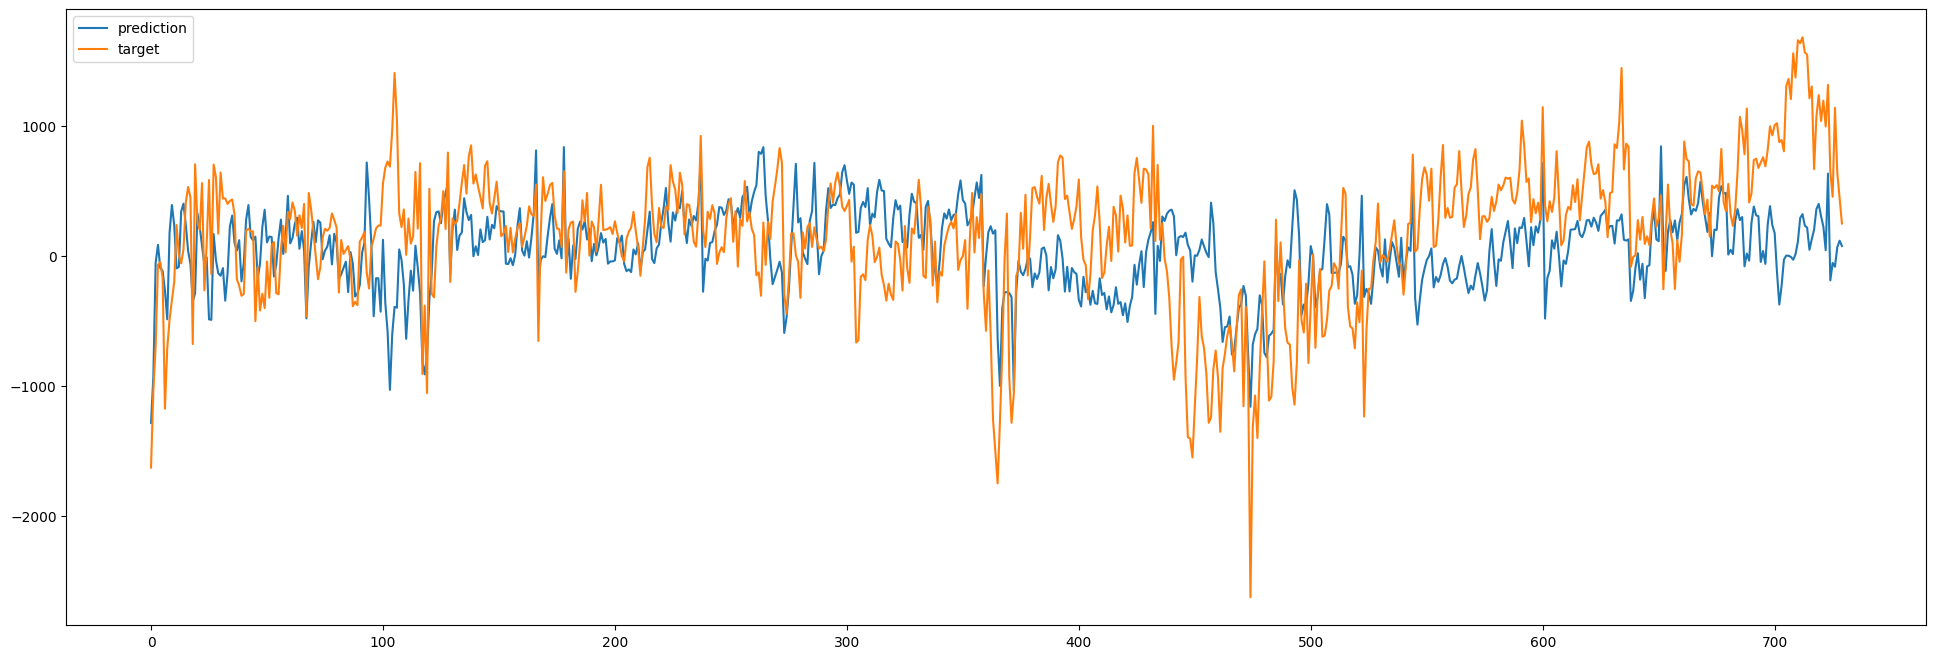

In [ ]:
val = train_dataset.get('val')
print(val[0].shape)
enc_in = val[0]
dec_in = val[1]
target = val[2]

#a = predict_inf(infenc, infdec, enc_in, dec_in)
prediction = model.predict([enc_in, dec_in])
fig=plt.figure(figsize=(24,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(scaler_y.inverse_transform(prediction.reshape(prediction.shape[1],1)), label = 'prediction')
plt.plot(scaler_y.inverse_transform(target.reshape(-1,1)), label = 'target')
plt.legend()

(1, 365, 33)
1/1 [==============================] - 1s 585ms/step
Target Sum: 359.476848226844
Prediction Sum: 350.44854736328125
Rescaled target value Sum: 314453.070241768
Rescaled prediction value Sum: 119516.359375
Absolute Error: 304274.6664390804
Percentage Deviation: 0.9676314058728639
MAE: 0.0802058835603168
MSE: 0.011257652059002546


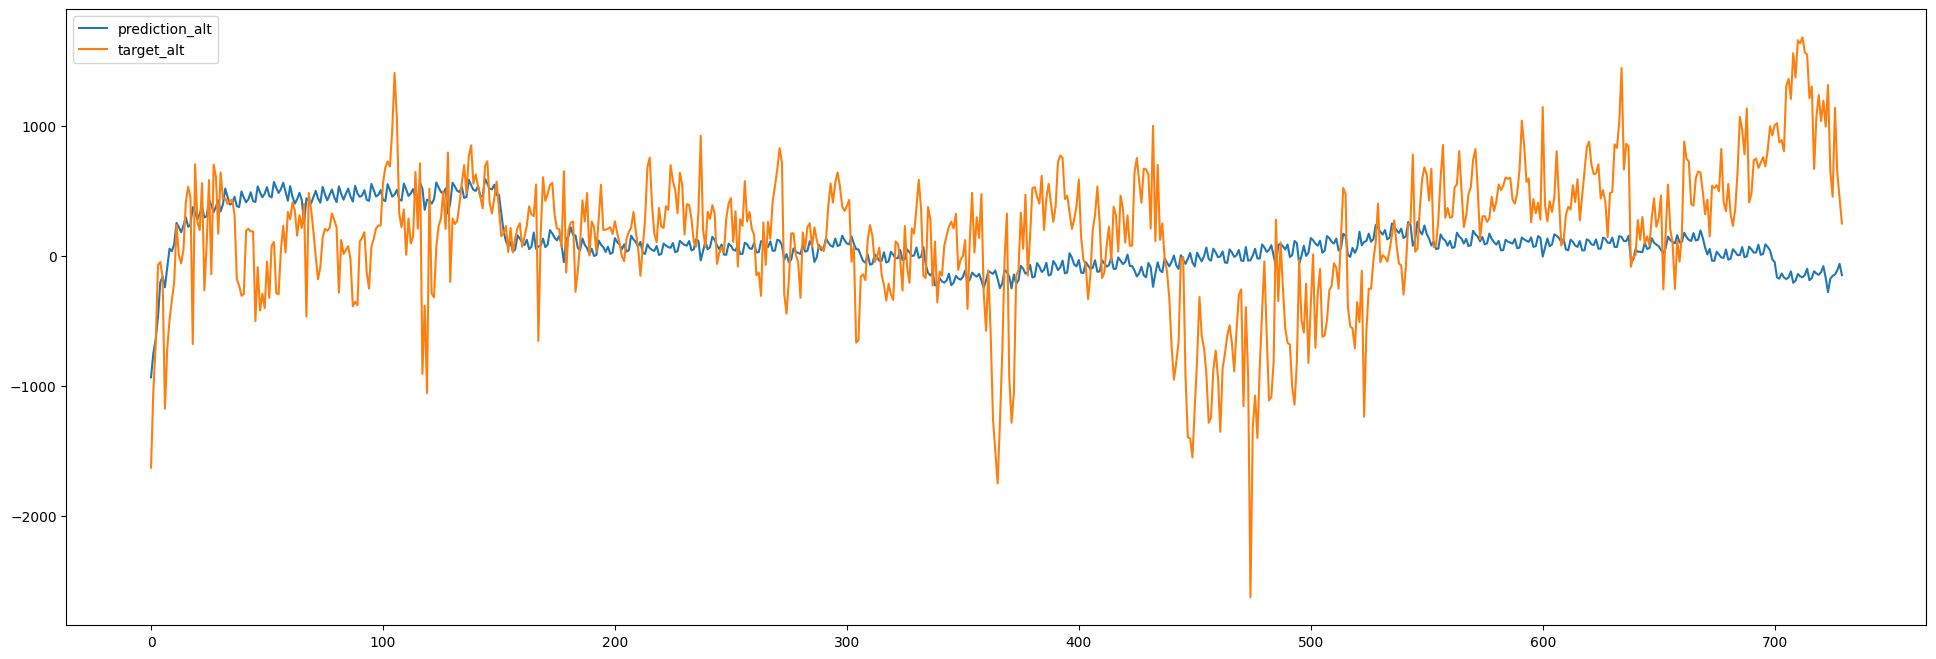

In [ ]:
val = train_dataset_alt.get('val')
print(val[0].shape)
enc_in_alt = val[0]
dec_in_alt = val[1]
target_alt = val[2]

#a = predict_inf(infenc, infdec, enc_in, dec_in)
prediction_alt = model_alt.predict([enc_in_alt, dec_in_alt])
fig=plt.figure(figsize=(24,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(scaler_y.inverse_transform(prediction_alt.reshape(prediction_alt.shape[1],1)), label = 'prediction_alt')
plt.plot(scaler_y.inverse_transform(target_alt.reshape(-1,1)), label = 'target_alt')
plt.legend()

def print_results(target_alt, prediction_alt, scaler_y):
    print(f'Target Sum: {target_alt.sum()}')
    print(f'Prediction Sum: {prediction_alt.reshape(prediction_alt.shape[1],1).sum()}')
    rescaled_pred = scaler_y.inverse_transform(prediction_alt.reshape(-1,1))
    rescaled_target = scaler_y.inverse_transform(target_alt.reshape(-1,1))
    target_value = np.absolute(rescaled_target[:]).sum()
    print(f'Rescaled target value Sum: {target_value}')
    pred_value = np.absolute(rescaled_pred[:]).sum()
    print(f'Rescaled prediction value Sum: {pred_value}')
    x = np.absolute(rescaled_target[:]-rescaled_pred[:]).sum()
    print(f'Absolute Error: {x}')
    print(f'Percentage Deviation: {x/target_value}')
    print(f'MAE: {mean_absolute_error(target_alt, prediction_alt.reshape(-1,1))}')
    print(f'MSE: {mean_squared_error(target_alt, prediction_alt.reshape(-1,1))}')
print_results(target_alt, prediction_alt, scaler_y)

## **Metrics**
Evaluate the results.

In [ ]:
def print_results(target, prediction, scaler_y):
    print(f'Target Sum: {target.sum()}')
    print(f'Prediction Sum: {prediction.reshape(prediction.shape[1],1).sum()}')
    rescaled_pred = scaler_y.inverse_transform(prediction.reshape(-1,1))
    rescaled_target = scaler_y.inverse_transform(target.reshape(-1,1))
    target_value = np.absolute(rescaled_target[:]).sum()
    print(f'Rescaled target value Sum: {target_value}')
    pred_value = np.absolute(rescaled_pred[:]).sum()
    print(f'Rescaled prediction value Sum: {pred_value}')
    x = np.absolute(rescaled_target[:]-rescaled_pred[:]).sum()
    print(f'Absolute Error: {x}')
    print(f'Percentage Deviation: {x/target_value}')
    print(f'MAE: {mean_absolute_error(target, prediction.reshape(-1,1))}')
    print(f'MSE: {mean_squared_error(target, prediction.reshape(-1,1))}')
print_results(target, prediction ,scaler_y)

Target Sum: 359.476848226844
Prediction Sum: 342.81884765625
Rescaled target value Sum: 314453.070241768
Rescaled prediction value Sum: 178061.3125
Absolute Error: 294075.4018755014
Percentage Deviation: 0.935196471923142
MAE: 0.07751738847349206
MSE: 0.010195344976663433


In [ ]:
def print_results(target_alt, prediction_alt, scaler_y):
    print(f'Target Sum: {target_alt.sum()}')
    print(f'Prediction Sum: {prediction_alt.reshape(prediction_alt.shape[1],1).sum()}')
    rescaled_pred = scaler_y.inverse_transform(prediction_alt.reshape(-1,1))
    rescaled_target = scaler_y.inverse_transform(target_alt.reshape(-1,1))
    target_value = np.absolute(rescaled_target[:]).sum()
    print(f'Rescaled target value Sum: {target_value}')
    pred_value = np.absolute(rescaled_pred[:]).sum()
    print(f'Rescaled prediction value Sum: {pred_value}')
    x = np.absolute(rescaled_target[:]-rescaled_pred[:]).sum()
    print(f'Absolute Error: {x}')
    print(f'Percentage Deviation: {x/target_value}')
    print(f'MAE: {mean_absolute_error(target_alt, prediction_alt.reshape(-1,1))}')
    print(f'MSE: {mean_squared_error(target_alt, prediction_alt.reshape(-1,1))}')
print_results(target_alt, prediction_alt, scaler_y)

Target Sum: 359.476848226844
Prediction Sum: 350.44854736328125
Rescaled target value Sum: 314453.070241768
Rescaled prediction value Sum: 119516.359375
Absolute Error: 304274.6664390804
Percentage Deviation: 0.9676314058728639
MAE: 0.0802058835603168
MSE: 0.011257652059002546


In [ ]:
print_results(target[:int(target.shape[0]/2)], prediction[:,:int(target.shape[0]/2)] ,scaler_y)

Target Sum: 178.4092709599118
Prediction Sum: 176.91204833984375
Rescaled target value Sum: 114877.427549911
Rescaled prediction value Sum: 93034.796875
Absolute Error: 114563.8297098419
Percentage Deviation: 0.9972701526596002
MAE: 0.060397359477841465
MSE: 0.006697278611541537


In [ ]:
print_results(target_alt[:int(target_alt.shape[0]/2)], prediction_alt[:,:int(target_alt.shape[0]/2)] ,scaler_y)

Target Sum: 178.4092709599118
Prediction Sum: 180.80221557617188
Rescaled target value Sum: 114877.427549911
Rescaled prediction value Sum: 84646.1015625
Absolute Error: 106470.58527231927
Percentage Deviation: 0.9268190239206114
MAE: 0.05613064970900994
MSE: 0.00542269643804263


In [ ]:
print_results(target[int(target.shape[0]/2):], prediction[:,int(target.shape[0]/2):] ,scaler_y)

Target Sum: 181.0675772669323
Prediction Sum: 165.9068145751953
Rescaled target value Sum: 199575.642691857
Rescaled prediction value Sum: 85026.515625
Absolute Error: 179511.57216565943
Percentage Deviation: 0.8994663363946855
MAE: 0.09463741746914267
MSE: 0.013693411341785327


In [ ]:
print_results(target_alt[int(target_alt.shape[0]/2):], prediction_alt[:,int(target_alt.shape[0]/2):] ,scaler_y)

Target Sum: 181.0675772669323
Prediction Sum: 169.64633178710938
Rescaled target value Sum: 199575.642691857
Rescaled prediction value Sum: 34870.2578125
Absolute Error: 197804.08116676114
Percentage Deviation: 0.9911233580350728
MAE: 0.10428111741162364
MSE: 0.01709260767996246


In [ ]:
sum(abs(target))

359.5667997305268

In [ ]:
sum(abs(target_alt))

359.5667997305268

In [ ]:
from google.colab import files

results=scaler_y.inverse_transform(prediction.reshape(prediction.shape[1],1))

df = pd.DataFrame(results)
csv_filename = 'result_datasets.csv'
df.to_csv(csv_filename, index=False)
files.download(csv_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

results_alt=scaler_y.inverse_transform(prediction_alt.reshape(prediction_alt.shape[1],1))

df = pd.DataFrame(results_alt)
csv_filename = 'result_datasets_alt.csv'
df.to_csv(csv_filename, index=False)
files.download(csv_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>